<h3 style="background-color:skyblue;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Libraries and Utilities</h3>


In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import networkx          as nx
import seaborn           as sns
from nltk                import ngrams
from pyvis.network       import Network
import os
import re
import nltk
import pydot
import spacy as sp
import pickle
from wordcloud import WordCloud
from tqdm.notebook import tqdm
tqdm.pandas()
from wordcloud import STOPWORDS
from string import punctuation
import enchant
import pickle
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
wchecker = enchant.Dict("en_US")
nlps = sp.load('en_core_web_sm')

%run BiGramGraph.ipynb

<h3 style="background-color:skyblue;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Graph Attribute Exploration</h3>


<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Chromatic Number</h3>


 
<h3 style="background-color:green;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Texts Dataset</h3>


In [2]:
def remove_punct(text):
    table=str.maketrans('','',punctuation)
    return text.translate(table)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def word_validation(text):
    words = text.split(' ')
    words = [i for i in words if wchecker.check(i) == True]
    return ' '.join(words)


In [3]:
#GLOVAL VARS

NFOLDER_PATH = '/Users/tomas/source/repos/NLP-Research-Exploring-Graph-Attributes/Source/Notebooks/'
NFOLDER_PATH = ''

In [4]:
multi_text = pd.read_parquet('multi_text_ds_no_stopwords.parquet')

In [5]:
multi_text.head(3)

,airport_reviews,amazon_alexa_reviwes,Anime_synopsis,bible_text,children_books,elonmusk_tweets,GBA_Games_plot,hp1_movie_script,medium_articles,movie_synopsis,nirvana_lyrics,poe_stories,Restaurant_Reviews,rick_and_morty_script,slogans,ham_sms,Terminator3,Terminator2,Terminator1,Womens_Clothing_reviews
0,airport certainly tiny arriving good plane qui...,love echo,order something obtained something equal value...,11 beginning god created heaven earth,every year evil protectorate offers baby evil ...,band robots spared humanity,game opens agent bond infiltrates stronghold o...,chapter one boy lived,oh headlines blared next big thing hopes sky h...,ted bellhops first night hotels unusual guests...,need easy friend ear lend think fit shoe clue ...,ways god nature providence ways models frame w...,wow loved place,gotta come jus gotta come,never follow keeping ahead technology everyone...,go point crazy available great world la buffet...,downtown la noon hot summer day extreme long lens,start tight wright hes intense powerful man,ext schoolyard night 1,absolutely wonderful silky sexy comfortable
1,small airports generally intimate friendly wel...,NaN,seeking restore diminishing hope survey corps ...,None,anna struggling understand new boy school one ...,exactly tesla absurdly overvalued based past,agent bond works alongside french intelligence...,number four privet drive proud say perfectly n...,found looking question concept syntax programm...,racing boxing match frank mike john bargained ...,whats season love cant everything whats reason...,chance good lady hath bereft thus quiet still ...,crust good,rick going,company advertising campaigns byte apple late ...,lar joking,lunchtime crowd stacks wall humanity slow motion,head shaven stares camera,silence gradually sound distant traffic becomes,love dress pretty happened find store glad nev...
2,waited hour corridor baggage arrival 3 hours w...,sometimes playing game answer question correct...,mad scientist rents room rickety old building ...,12 earth without form void darkness upon,browns swimming ambitions sank without trace f...,None,None,director firm called made drills big beefy man...,machine learning increasingly moving models au...,labels new project experimental music document...,shame go shame shame go shame shame go got oh ...,passus de bristly bore let us hurry walls said...,tasty texture nasty,got surprise,new arriving nonstop know fly two great airlin...,None,move herds among glittering rows cars jammed b...,resigned expression hear voice priest,audible low angle bounded one side,high hopes dress really wanted work initially ...


In [6]:
# bigram_models = []

# for column in tqdm(multi_text.columns):
#     data = multi_text[column][multi_text[column].notna()]
#     G = BiGramGraph(data=data,notebook=True)
#     G.Name=column
#     G.add_part_of_speech()
#     bigram_models.append(G)

In [7]:
# #Save Models
# with open("/Users/Tomas/Documents/GitHub/NLP-Research-Exploring-Graph-Attributes/Source/Notebooks/multi_text_model_list.pkl", "wb") as file:
#     pickle.dump([i.dump() for i in bigram_models],file)

In [8]:
# Load Pre Fitted Models
with open(NFOLDER_PATH+"multi_text_model_list.pkl", "rb") as file:
    bigraph_models = [BiGramGraph(prebuild=attributes,notebook=True) for attributes in pickle.load(file)]

In [9]:
#try and remove self loops
for g in bigraph_models:
    g.remove_self_loops()
    #g.add_entities_of_speech()

In [250]:
for idx,graph in enumerate(bigraph_models):
    print(idx+1,') Dataset Name: [',graph.Name,']\n',graph,'\n','--'*20)

1 ) Dataset Name: [ airport_reviews ]
 Number of words included: 9231
Number of edges included: 108142
Chromatic number: 24
 
 ----------------------------------------
2 ) Dataset Name: [ amazon_alexa_reviwes ]
 Number of words included: 3420
Number of edges included: 22249
Chromatic number: 13
 
 ----------------------------------------
3 ) Dataset Name: [ Anime_synopsis ]
 Number of words included: 20835
Number of edges included: 289590
Chromatic number: 24
 
 ----------------------------------------
4 ) Dataset Name: [ bible_text ]
 Number of words included: 11741
Number of edges included: 195863
Chromatic number: 33
 
 ----------------------------------------
5 ) Dataset Name: [ children_books ]
 Number of words included: 1864
Number of edges included: 3249
Chromatic number: 4
 
 ----------------------------------------
6 ) Dataset Name: [ elonmusk_tweets ]
 Number of words included: 4927
Number of edges included: 18175
Chromatic number: 7
 
 ---------------------------------------

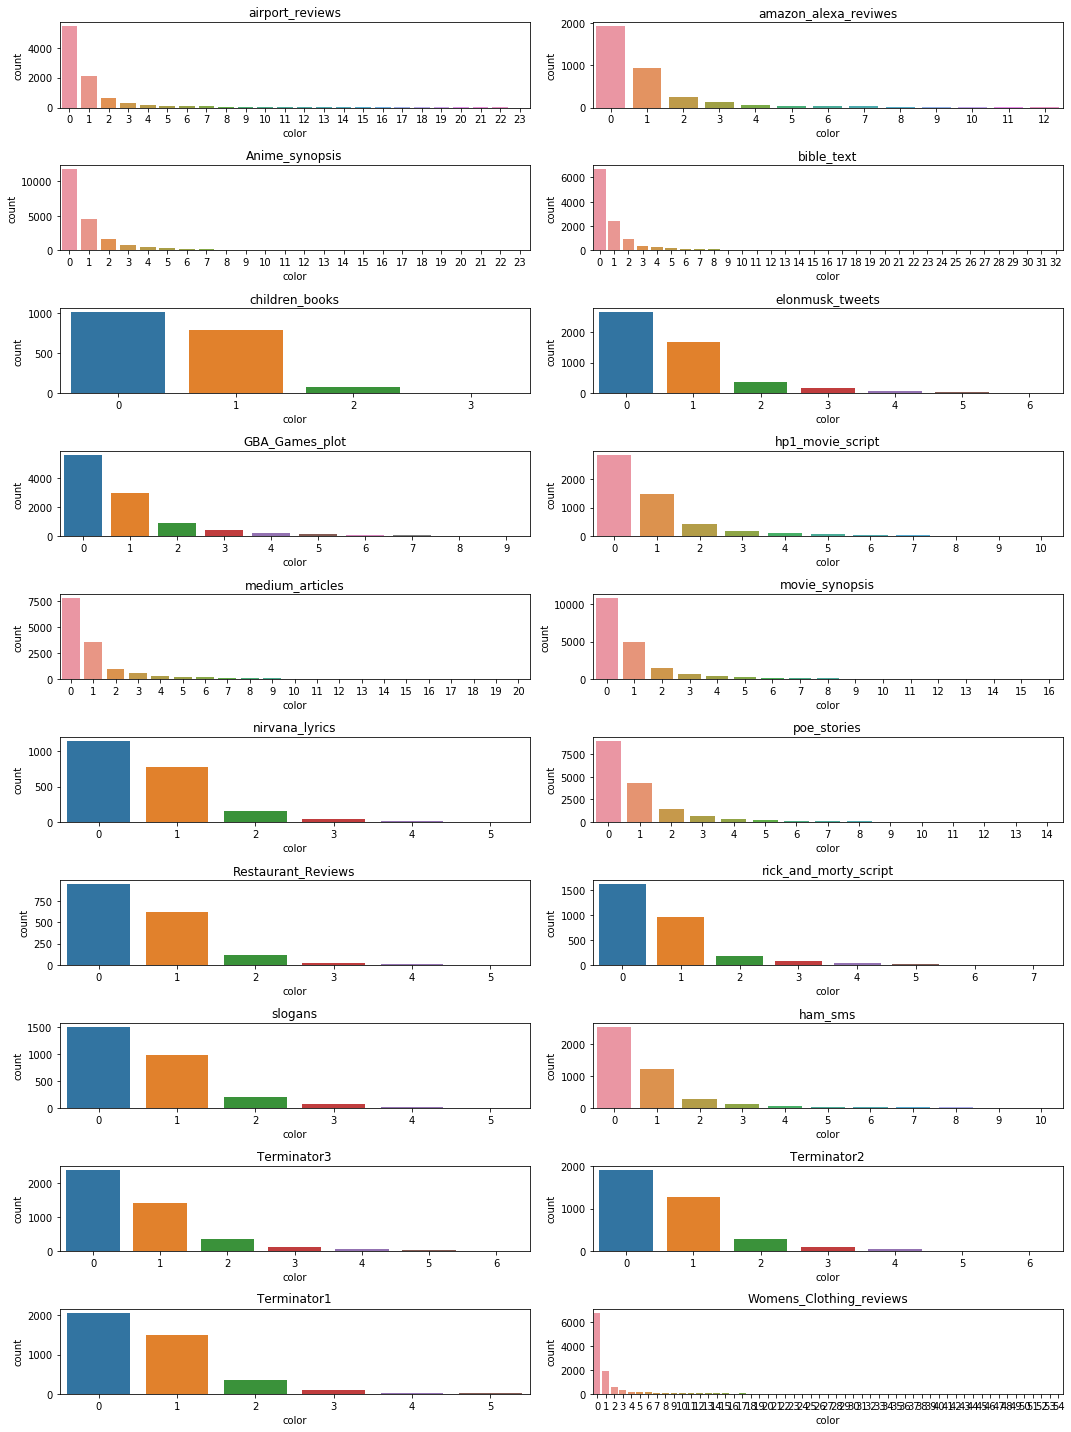

In [251]:
plt.figure(figsize=(15,20))
#plt.subtitle('Distribution of Color Tags')
for idx,graph in enumerate(bigraph_models):
    plt.subplot(10,2,idx+1)
    plt.title(graph.Name)
    sns.countplot(x=graph.Data.color)
plt.tight_layout()
plt.show()

In [252]:
'''
Question 1) Are there any connections between low count colors
Question 2) Low dimnesion representation of chromatic vector
Question 3) Is there any connection between part of speech and chromatic number
Question 4) 
'''

'\nQuestion 1) Are there any connections between low count colors\nQuestion 2) Low dimnesion representation of chromatic vector\nQuestion 3) Is there any connection between part of speech and chromatic number\nQuestion 4) \n'

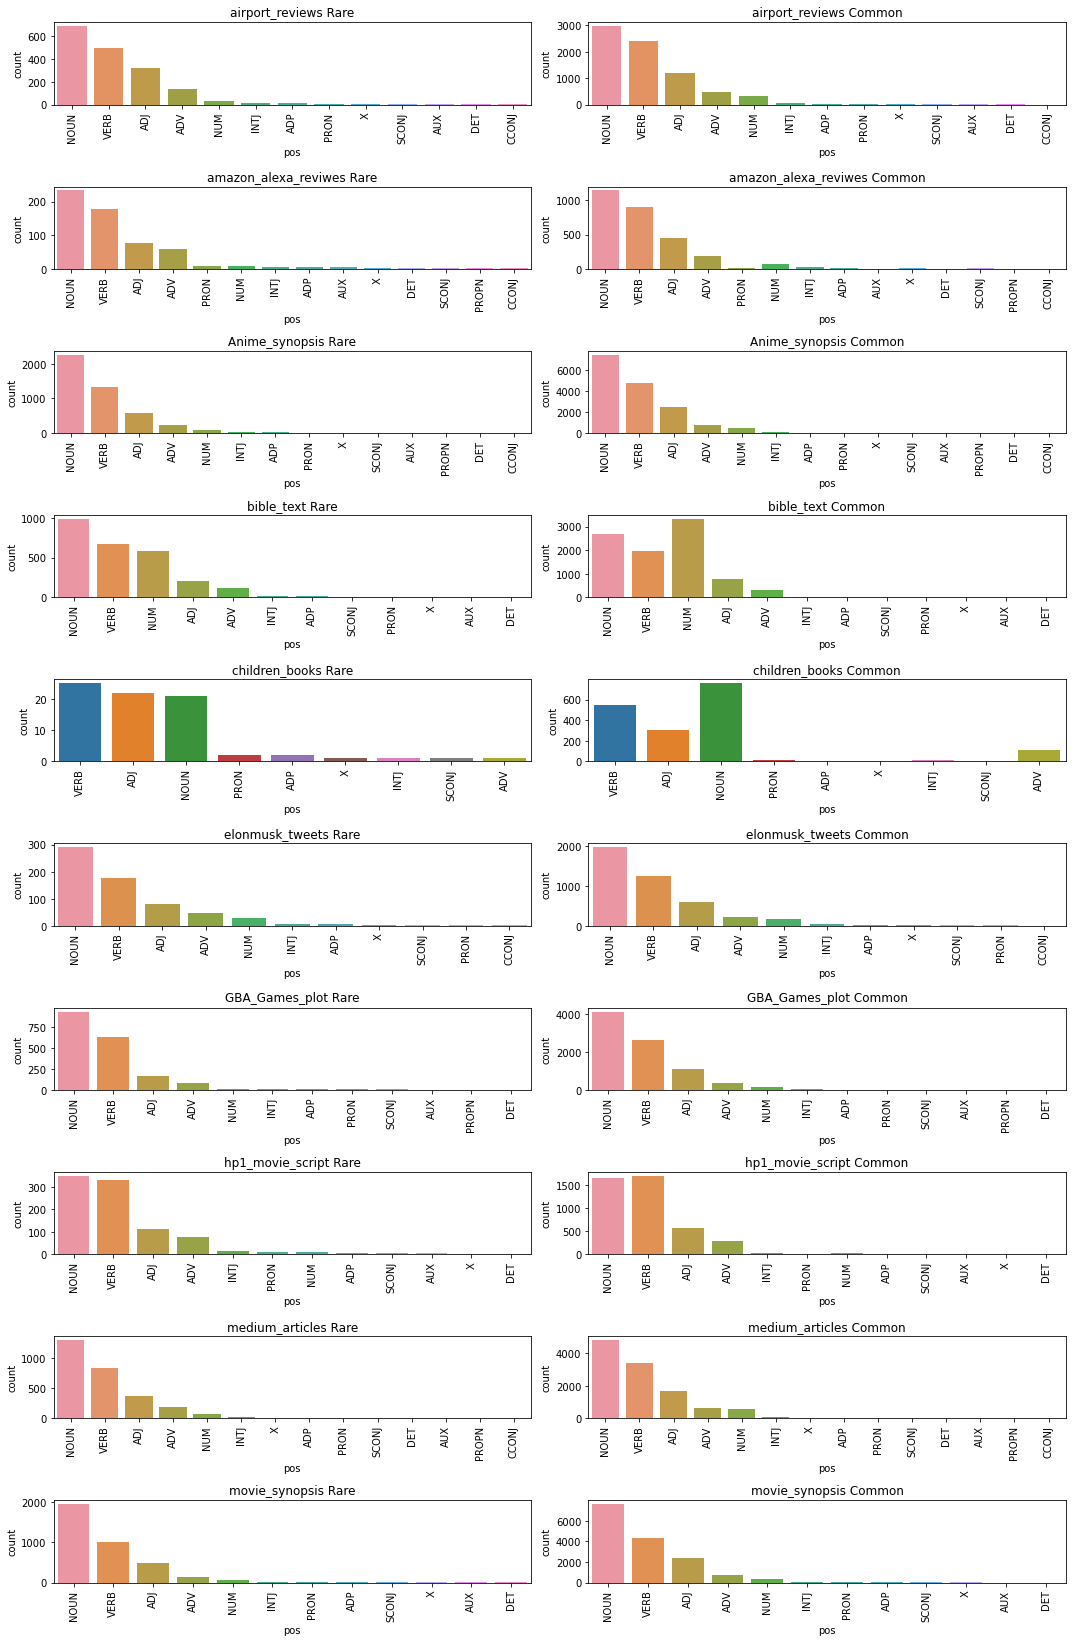

In [399]:

plt.figure(figsize=(15,45))
#plt.subtitle('Distribution of Color Tags')
for idx,graph in zip(range(1,20,2),bigraph_models):
    #calculating rare and common
    threshold = np.round(graph.Data.color.value_counts().max()*0.2)
    color_counts = graph.Data.color.value_counts()
    rare_color_counts = color_counts[color_counts<threshold]
    common_color_counts = color_counts[color_counts>threshold]

    query = ' '.join(f'color == {i} or' for i in rare_color_counts.index)
    query = query[:-3]
    rare_under_testing = graph.Data.query(query)
    rare_under_testing

    query = ' '.join(f'color == {i} or' for i in common_color_counts.index)
    query = query[:-3]
    common_under_testing = graph.Data.query(query)
    common_under_testing

    plt.subplot(20,2,idx)
    plt.title(graph.Name +' Rare')
    ax=sns.countplot(x=rare_under_testing.pos,order=rare_under_testing.pos.value_counts().index)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.subplot(20,2,idx+1)
    plt.title(graph.Name+' Common')
    ax=sns.countplot(x=common_under_testing.pos,order=rare_under_testing.pos.value_counts().index)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    
plt.tight_layout()
plt.show()



In [130]:
# Claculating Text Variance
def text_variabilty(corpus):
    explained_var = 0
    N = 20
    CV=CountVectorizer()
    VECTORIZED = CV.fit_transform(corpus)
    while True:
        L_DIM = TruncatedSVD(N)
        L_DIM.fit(VECTORIZED.todense())
        explained_var = np.sum(L_DIM.explained_variance_ratio_)
        if explained_var >= 0.8:
            break
        else:
            N +=50
    return N,explained_var


In [131]:
variance_dict = dict()
for column in tqdm(multi_text.columns):
    variance_dict[column] = text_variabilty(multi_text[column][multi_text[column].notna()])

  0%|          | 0/20 [00:00<?, ?it/s]

In [479]:
# #Save variance dict
# with open("/Users/Tomas/Documents/GitHub/NLP-Research-Exploring-Graph-Attributes/Source/Notebooks/multi_ds_variance.pkl", "wb") as file:
#     pickle.dump(variance_dict,file)

#load variance dict
with open(NFOLDER_PATH+"/multi_ds_variance.pkl", "rb") as file:
    variance_dict = pickle.load(file)

In [480]:
variance_dict

{'airport_reviews': (570, 0.8142720659834938),
 'amazon_alexa_reviwes': (270, 0.8012111418669756),
 'Anime_synopsis': (1520, 0.8006037749365807),
 'bible_text': (1220, 0.8051658761897419),
 'children_books': (70, 1.000000000000013),
 'elonmusk_tweets': (820, 0.8111496968910208),
 'GBA_Games_plot': (120, 0.8401392524381162),
 'hp1_movie_script': (570, 0.8039603176039611),
 'medium_articles': (70, 0.8575481676553128),
 'movie_synopsis': (1920, 0.8003652757969427),
 'nirvana_lyrics': (70, 0.9125791190035515),
 'poe_stories': (70, 0.9999999999999997),
 'Restaurant_Reviews': (320, 0.8187803390937398),
 'rick_and_morty_script': (370, 0.8146211654404436),
 'slogans': (170, 0.8037214393223232),
 'ham_sms': (570, 0.8032334191920281),
 'Terminator3': (970, 0.8115431487677219),
 'Terminator2': (870, 0.8084704718379417),
 'Terminator1': (1070, 0.81319901851725),
 'Womens_Clothing_reviews': (620, 0.812063153216553)}

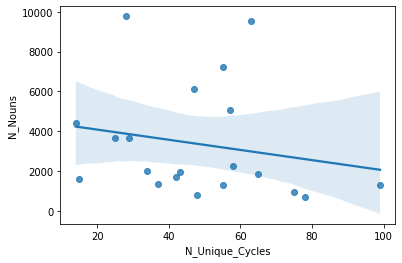

In [483]:
N_for_80_variance = [i[0] for i in list(variance_dict.values())]
chrom_nums = [i.get_Xi() for i in bigraph_models]
indeg_max = [i.In_Max_Deg for i in bigraph_models]
outdeg_max = [i.Out_Max_Deg for i in bigraph_models]
n_nouns =  [i.Data.pos.value_counts().loc['NOUN'] for i in bigraph_models]
n_verbs =  [i.Data.pos.value_counts().loc['VERB'] for i in bigraph_models]
n_nodes =  [i.Data.shape[0] for i in bigraph_models]
n_edges =  [i.N_edges for i in bigraph_models]
#n_u_cyclyes = [len(i.get_All_Unique_Cycles()) for i in bigraph_models]
#all_unique_cycles =  [len(i.get_All_Unique_Cycles()) for i in bigraph_models]

var_chrom_df = pd.DataFrame({'NComp':N_for_80_variance,'ChromN':chrom_nums,
                            'In_Max_Deg':indeg_max,'Out_Max_Deg':outdeg_max,
                            'N_Nouns':n_nouns,'N_Verbs':n_verbs,'N_Words':n_nodes,'N_Edges':n_edges,
                            'N_Unique_Cycles':n_u_cyclyes})


sns.regplot(data=var_chrom_df,x='N_Unique_Cycles',y='ChromN')
#bigraph_models[0].

<Figure size 2160x2160 with 0 Axes>

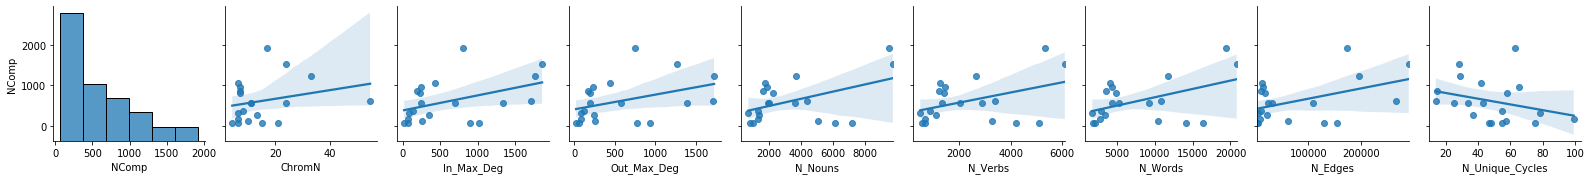

In [490]:
plt.figure(figsize=(30,30))
sns.pairplot(var_chrom_df,kind='reg',y_vars=['NComp'])

In [ ]:
#Vectorizing 
vectorized = []
for i in tqdm(example_corpus):
    vectorized.append(Bigraph.vectorize(i))


In [ ]:
pad_size = example_corpus.apply(lambda x: len(x)).max()
vec_norm = []
for vec in vectorized:
    V = np.zeros(pad_size)-1
    V[:len(vec)] = vec
    vec_norm.append(np.array(V))
vec_norm = np.array(vec_norm)    

In [ ]:
from scipy.spatial import distance_matrix

dm = distance_matrix(vec_norm,vec_norm)

In [ ]:
from sklearn.neighbors import NearestNeighbors
NN = NearestNeighbors(n_neighbors=2,metric='cosine')

NN.fit(vec_norm)
distances, indices = NN.kneighbors(vec_norm)
NN

In [ ]:
#intersection between NN
for x,y in indices[:5]:
    INSC = set(example_corpus[x].split()) & set(example_corpus[y].split())
    print((INSC))

In [ ]:
#Cosine Distance
from scipy.spatial.distance import cosine
for x,y in indices[:5]:
    INSC = cosine(vec_norm[x,:],vec_norm[y,:])
    print((INSC))

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">New Distance Metric Using Chromatic Number</h3>


In [162]:
'''
formula = (number of identical words having the same chromatic number in both graphs) / (number of identical words in both graphs)
'''

'\nformula = (number of identical words having the same chromatic number in both graphs) / (number of identical words in both graphs)\n'

$$T_{1,2} = \text{Sets of Words in BiGramGraphs of Corpora 1 and 2}$$ 
$$ I = ||T_{1} \cap T_{2}||$$
$$ IC = ||(T_{1} \cap T_{2})  \wedge (T_{1 chrom} \cap T_{2 chrom})||$$

$$D_{chrom} = \frac{IC}{I}$$

In [646]:
def chromatic_distance(graph_1,graph_2):
    
    if 'pos' not in graph_1.Data.columns or   'pos' not in graph_2.Data.columns:
        raise PosError('Please Calculate PartofSpeech for Each Graph')
    
    overlaping_words = set(graph_1.Data['word'])
    overlaping_words = overlaping_words & set(graph_2.Data['word'])
    
    I = len(overlaping_words)
     
    chrom_ds = pd.DataFrame(index = list(overlaping_words))
    chrom_ds['chrom1'] = graph_1.Data.set_index('word').loc[overlaping_words].color
    chrom_ds['chrom2'] = graph_2.Data.set_index('word').loc[overlaping_words].color
    same_chrom_num = chrom_ds.apply(lambda x: np.mean(x) == x[0] ,axis=1)
    chrom_ds = chrom_ds[same_chrom_num].rename(columns={'chrom1':'color'}).drop(columns=['chrom2'])
    
    #Epsilon
    E = 0
    chrom_ds['weight1'] = chrom_ds.index.to_series().apply(lambda x:graph_1.Graph.degree(x) )
    #graph_1.Data.set_index('word').loc[overlaping_words].pos
    chrom_ds['weight2'] = chrom_ds.index.to_series().apply(lambda x:graph_2.Graph.degree(x) )
    #same_weight = chrom_ds.apply(lambda x: np.max(x)<=2*np.min(x) ,axis=1)
    same_weight = chrom_ds[['weight1','weight2']].apply(lambda x: np.mean(x) == x[0] ,axis=1)
    same_weight = chrom_ds[same_weight]
    
    ICW = len(same_weight)
    IC = len(chrom_ds)
    
    return ICW/I



#TO DELETE ========================

def chromatic_distance_DEC(graph_1,graph_2):
    overlaping_words = set(graph_1.Data['word'])
    overlaping_words = overlaping_words & set(graph_2.Data['word'])
    
    I = len(overlaping_words)
    
    chrom_ds = pd.DataFrame(index = list(overlaping_words))
    chrom_ds['chrom1'] = graph_1.Data.set_index('word').loc[overlaping_words].color
    chrom_ds['chrom2'] = graph_2.Data.set_index('word').loc[overlaping_words].color
    same_chrom_num = chrom_ds.apply(lambda x: np.mean(x) == x[0] ,axis=1)
    chrom_ds = chrom_ds[same_chrom_num].rename(columns={'chrom1':'color'}).drop(columns=['chrom2'])
    
    #Epsilon
    E = 0
    chrom_ds['weight1'] = chrom_ds.index.to_series().apply(lambda x:graph_1.Graph.degree(x) )
    #graph_1.Data.set_index('word').loc[overlaping_words].pos
    chrom_ds['weight2'] = chrom_ds.index.to_series().apply(lambda x:graph_2.Graph.degree(x) )
    #same_weight = chrom_ds.apply(lambda x: np.max(x)<=2*np.min(x) ,axis=1)
    same_weight = chrom_ds[['weight1','weight2']].apply(lambda x: np.mean(x) == x[0] ,axis=1)
    same_weight = chrom_ds[same_weight]
    
    ICW = len(same_weight)
    IC = len(chrom_ds)
    
    return IC,I,same_weight


In [647]:
distance_matrix = []
for i in tqdm(bigraph_models):
    row = []
    for j in bigraph_models:
        row.append(chromatic_distance(i,j))
    distance_matrix.append(row)

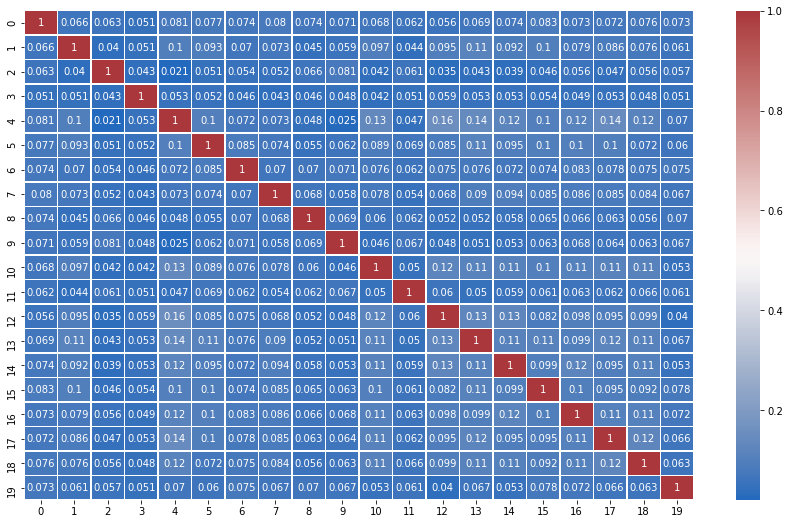

In [648]:
DM = np.array([np.array(i) for i in distance_matrix])
plt.figure(figsize=(15,9))
sns.heatmap(DM,annot=True,cmap='vlag',linewidth=0.5)
plt.show()

In [652]:
A = 17
B = 4

In [653]:
chromatic_distance(bigraph_models[A],bigraph_models[B])

0.14464534075104313

In [654]:
bigraph_models[A].Graph.degree('la')

DiDegreeView({})

In [655]:
IC,I,chrom_ds = chromatic_distance_DEC(bigraph_models[A],bigraph_models[B])

In [656]:
print('IC: ',IC)
print('I: ',I)
print('UNIQUE CHROMATIC NUMBERS: ',chrom_ds.color.unique())

IC:  298
I:  719
UNIQUE CHROMATIC NUMBERS:  [1 0 2]


In [657]:
print(bigraph_models[A],'\n Name: ',bigraph_models[A].Name)

Number of words included: 3595
Number of edges included: 10972
Chromatic number: 7
 
 Name:  Terminator2


In [658]:
print(bigraph_models[B],'\n Name: ',bigraph_models[B].Name)

Number of words included: 1864
Number of edges included: 3249
Chromatic number: 4
 
 Name:  children_books


In [683]:
chrom_ds

,color,weight1,weight2
delighted,1,2,2
interested,0,2,2
tunnel,0,2,2
sides,0,2,2
wearing,1,2,2
...,...,...,...
connected,0,2,2
friends,1,8,8
aid,1,2,2
store,0,2,2


<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Paths</h3>


<h3 style="background-color:purple;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;">Missing Replacment Using Paths</h3>


In [870]:
# x1 x2 x3 nan x4 x5  --> get best path if exsits between x3 and x4

def iterative_path_search(Graph,source,target,iters=10,mode = 'minimum'):
    if mode == 'maximum':
        results = []
        max_weight =0
        GEN = Graph.get_Shortest_Simple_Path(source,target)
        for ax,i in tqdm(enumerate(GEN),leave=False):
            if ax == iters:
                break
            n_path =list( nltk.ngrams(i,2))
            c_weight = calculate_path_weight(bigraph_models[0],n_path) 
            if max_weight < c_weight:
                results = i
                max_weight = c_weight
        return results

                
    
    elif mode == 'minimum':
        results = []
        min_weight =99999
        GEN = Graph.get_Shortest_Simple_Path(source,target)
        for ax,i in tqdm(enumerate(GEN),leave=False):
            if ax == iters:
                break
            n_path =list( nltk.ngrams(i,2))
            c_weight = calculate_path_weight(bigraph_models[0],n_path) 
            if min_weight > c_weight:
                results = i
                min_weight = c_weight
        return results
        
    else:
        raise(SyntaxError())

def Bigraph_Imputer(form,Graph):
    missing_labeld = []
    start =0
    tokens = form.split(' ')
    
    for ax,word in enumerate(tokens):
        if word in ['NaN']:
            missing_labeld.append({'NaN':[start,form.find(' ',start+3)],
                                  'Prev_Word' :'' if ax == 0 else tokens[ax-1],
                                   'Next_Word' : '' if ax == len(tokens)-1 else tokens[ax+1]})
        if ax != 0 or len(tokens)-1:
            start+=(len(word)+1)
        else:
            start+=len(word)

    paths = []
    for missing in missing_labeld:
        paths.append(Graph.get_Shortest_Path(missing['Prev_Word'],missing['Next_Word']))
        
    final = form
    last_added = 0
    for path,missing in zip(paths,missing_labeld):
        start = missing['NaN']
        end   = start[1]
        start = start[0]
        if len(path) == 2:
            final = final[:start+last_added] + final[end+last_added+1:]
            last_added += (len(' '.join(path[1:-1])))-4          
        else:
            final = final[:start+last_added] +' '.join(path[1:-1]) + final[end+last_added:]
            last_added += (len(' '.join(path[1:-1])))-3            
    return final


In [901]:
print(bigraph_models[9].Name)
print(multi_text.iloc[12,9])

movie_synopsis
browns endless summer one first influential surf movies time film documents surfers mike august travel world winter back 1965 surfing search perfect wave ultimately endless summer


In [883]:
test_string='crush NaN airport'

In [884]:
#iterative_path_search(bigraph_models[0],'straight','staff',mode='maximum',iters=500)

In [885]:
print(Bigraph_Imputer(test_string,bigraph_models[0]))


crush worst airport


In [788]:
#calculate_path_weight(bigraph_models[0],list(nltk.ngrams(paths[0],2)))

In [ ]:
'''

Question 1) Heaviest Path Between Two Nodes
Question 2) Generate A Random Chromatic Vector and Generate the heaviest walk between the vector members

'''

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Random Chromatic Walk</h3>


In [902]:
class ChromaticRandomWalker:
    
    
    def __init__(self,Graph):
        self.Graph = Graph
        self.max_xi    = Graph.get_Xi()
        
    
    def __repr__(self):
        return self.Graph.__repr__()
        
    def generate_chromatic_vector(self,max_xi,size):
        chromatic_nums = list(range(max_xi))
        last_num = -1
        chrom_vec = []
        for i in range(size):
            index = np.floor((np.random.beta(1.5,1.5,1)*max_xi)[0])
            cur_choice = chromatic_nums[int(index)]
            while cur_choice == last_num:
                index = np.floor((np.random.beta(6,2,1)*max_xi)[0])
                cur_choice = chromatic_nums[int(index)]
            if cur_choice != last_num:
                last_num=cur_choice
                chrom_vec.append(cur_choice)
            else:
                continue
        self.Random_Chromatic_Vec = chrom_vec
    def calculate_path_weight(self,path):
        weight = 0
        start = path[0]
        for i in path[1:]:
            weight += self.Graph.Edges[(self.Graph.Edges['in'] == start)&(self.Graph.Edges.out == i)].weight.values[0]
            start =i
        return weight
    
    def generate(self,method='heaviest',vec_size = 5, depth=10):
        self.vec_size  = vec_size        
        self.generate_chromatic_vector(self.max_xi,self.vec_size)
        result = ' '
        first_word   = self.Graph.Data[self.Graph.Data.color==self.Random_Chromatic_Vec[0]].sample(1).word.values[0]
        for n in tqdm(self.Random_Chromatic_Vec[1:]):
            #Calculate Best Path
            paths = []
            targets = self.Graph.Data[self.Graph.Data.color==n]
            targets = targets.sample(depth if len(targets) >=depth else len(targets))
            for target in tqdm(targets.word,leave=False):
                gen = self.Graph.get_Shortest_Simple_Path(first_word,target)
                paths.append(next(gen))
            weights = np.array([self.calculate_path_weight(i) for i in paths])
            if method == 'heaviest':
                best_walk = paths[np.argmax(weights)]
                first_word = targets.word.values[np.argmax(weights)]
            elif method =='lightest':
                best_walk = paths[np.argmin(weights)]
                first_word = targets.word.values[np.argmin(weights)]
            elif method =='density_max':
                weights = [calculate_path_density(self.Graph,nltk.ngrams(i,2)) for i in paths]
                best_walk = paths[np.argmax(weights)]
                first_word = targets.word.values[np.argmax(weights)]
            elif method =='density_min':
                weights = [calculate_path_density(self.Graph,nltk.ngrams(i,2)) for i in paths]
                best_walk = paths[np.argmin(weights)]
                first_word = targets.word.values[np.argmin(weights)]
            del weights
            result += ' '.join(best_walk[:-1])+' '

        return result


In [909]:
RCW = ChromaticRandomWalker(bigraph_models[14])

In [911]:
RCW.generate(vec_size=5,method='heaviest')

' nutrition life better needs affordable getting least best western world change better best ice cream taste us 1982 '

In [912]:
RCW.Random_Chromatic_Vec

[0, 1, 3, 4, 2]

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Strongly Connected Components</h3>


In [21]:
gen = bigraph_models[16].get_Number_Strongly_Connected_Components()
bigraph_models[16].remove_self_loops()
gen = list(bigraph_models[16].get_Strongly_Connected_Components())


<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Density of Nodes - Regions of High Density</h3>


In [418]:
bigraph_models[16].extract_K_Core(notebook=True)

In [1002]:
KCORES = []
for ax,i in enumerate(bigraph_models):
    print(ax,') ',i.Name)
    KCORES.append(i.extract_K_Core(notebook=True))

0 )  airport_reviews
1 )  amazon_alexa_reviwes
2 )  Anime_synopsis
3 )  bible_text
4 )  children_books
5 )  elonmusk_tweets
6 )  GBA_Games_plot
7 )  hp1_movie_script
8 )  medium_articles
9 )  movie_synopsis
10 )  nirvana_lyrics
11 )  poe_stories
12 )  Restaurant_Reviews
13 )  rick_and_morty_script
14 )  slogans
15 )  ham_sms
16 )  Terminator3
17 )  Terminator2
18 )  Terminator1
19 )  Womens_Clothing_reviews


In [994]:
N = 8

bigraph_models[N].Name

'medium_articles'

In [995]:
bigraph_models[N]

Number of words included: 14085
Number of edges included: 153422
Chromatic number: 21

In [996]:
print('Maximum Out Degree ',bigraph_models[N].Out_Max_Deg)
print('Maximum in Degree ',bigraph_models[N].In_Max_Deg)
print('Minimum Out Degree ',bigraph_models[N].Out_Min_Deg)
print('Minimum in Degree ',bigraph_models[N].In_Min_Deg)

Maximum Out Degree  776
Maximum in Degree  904
Minimum Out Degree  1
Minimum in Degree  1


In [997]:
KCORE  = bigraph_models[N].extract_K_Core(notebook=True)
KCORE

Number of words included: 310
Number of edges included: 17460
Chromatic number: 21

In [998]:
print('Maximum Out Degree ',KCORE.Out_Max_Deg)
print('Maximum in Degree ',KCORE.In_Max_Deg)
print('Minimum Out Degree ',KCORE.Out_Min_Deg)
print('Minimum in Degree ',KCORE.In_Min_Deg)

Maximum Out Degree  189
Maximum in Degree  188
Minimum Out Degree  7
Minimum in Degree  22


In [1000]:
KCORE

Number of words included: 310
Number of edges included: 17460
Chromatic number: 21

In [1003]:
distance_matrix = []
for i in tqdm(KCORES):
    row = []
    for j in KCORES:
        row.append(chromatic_distance(i,j))
    distance_matrix.append(row)

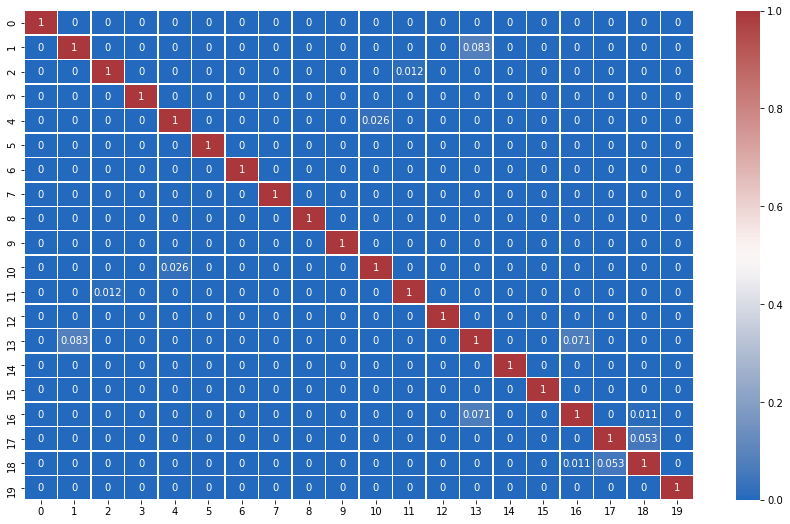

In [1004]:
DM = np.array([np.array(i) for i in distance_matrix])
plt.figure(figsize=(15,9))
sns.heatmap(DM,annot=True,cmap='vlag',linewidth=0.5)
plt.show()

In [1011]:
set(KCORES[13].Data.word)&set(KCORES[16].Data.word)

{'NaN',
 'back',
 'come',
 'go',
 'got',
 'guys',
 'know',
 'look',
 'now',
 'okay',
 'one',
 'right',
 'see',
 'time'}

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Design A Clustring Algorithms Based on The Graph</h3>


In [ ]:
# Using some arbitrary alpha value we decide how far can we walk from a -
#spesific node in terms of the edge weights using dikstra for example

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">KCORE/CHROM VEC Modeling Contirbution</h3>


In [1084]:
KCORES[12]

Number of words included: 61
Number of edges included: 413
Chromatic number: 6

In [1069]:
def KCORE_IMPUTE(x,KCORE):
    if x ==None:
        return 'NaN'
    else:
        R = []
        L = KCORE.Data.word.to_list()
        for word in x.split(' '):
            if word in L:
                R.append(word)
        return ' '.join(R)

In [1085]:
pp = multi_text.iloc[:,12].apply(KCORE_IMPUTE,args=[KCORES[12]])
pp = pp[pp.str.len()>3]

In [1086]:
pp

0                              place
1                               good
2                              tasty
4               selection menu great
5                               want
                   ...              
994                     disappointed
995                       think food
997                  overall go back
998    experience think well go time
999                             time
Name: Restaurant_Reviews, Length: 692, dtype: object

In [1087]:
#copy 
C = bigraph_models[12].dump()
C = BiGramGraph(prebuild=C)

In [1101]:
def remove_K_Core(Graph):
    C = Graph.dump()
    C = BiGramGraph(prebuild=C)
    KCORE = Graph.extract_K_Core(notebook=True)
    Data = C.Data.copy().set_index('word')
    for node in KCORE.Data.word:
        try:
            C.Graph.remove_node(node)
        except:
            pass

    L = list(set(C.Data.word)-set(KCORE.Data.word))

    Data = Data.loc[L].reset_index()
    C.Data = Data
    return C


In [1140]:
KCORE_LONE_SOLDIERS = []


In [1141]:
for model in tqdm(bigraph_models):
    WKC = remove_K_Core(model)
    degrees = list(WKC.Graph.degree(WKC.Graph.nodes))
    degrees = pd.DataFrame({'word':[i[0] for i in degrees],'deg':[i[1] for i in degrees]})
    KCORE_LONE_SOLDIERS.append(degrees[degrees.deg==0].shape[0])

In [1142]:
var_chrom_df['Droped_After_KCORE'] = KCORE_LONE_SOLDIERS

In [1151]:
#plt.figure(figsize=(30,30),dpi=400)
#sns.pairplot(var_chrom_df,kind='reg')#,y_vars=['NComp'])

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

In [17]:
class ChromaticVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, Graph):
        self.Graph = Graph
        self.text_transformer = self.Graph.vectorize

    def fit(self, X, y=None):
        self.vec = self.text_transformer(X)
        return self

    def transform(self, X, y=None):
        _X = self.text_transformer(X)
        diff = _X.shape[1] - self.vec.shape[1]
        if diff == 0:
            return _X
        
        elif diff < 0:
            return np.concatenate((_X, np.zeros((_X.shape[0], abs(diff)))), axis=1)
        
        else:
            return _X[:, :-diff]
            
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.vec.copy()
    
class CountV(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.text_transformer = CountVectorizer(stop_words='english')
       
    def fit(self, X, y=None):
        return self.text_transformer.fit(X, y)

    def transform(self, X, y=None):
        return self.text_transformer.transform(X.squeeze()).toarray()
    
    def fit_transform(self, X, y=None):
        return self.text_transformer.fit_transform(X.squeeze()).toarray()

In [16]:
y = pd.read_csv('Restaurant_Reviews.tsv', sep='\t')['Liked']

In [17]:
X = multi_text['Restaurant_Reviews'].dropna()
y = y[X.index]

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
%%capture
all_models = [LogisticRegression(), SVC(probability=True), MultinomialNB(), GaussianNB(), BernoulliNB(), 
              DecisionTreeClassifier(), RandomForestClassifier(), AdaBoostClassifier()]
BOW_results = np.zeros((len(all_models), 3))
CH_results = BOW_results.copy()

for i, _model in enumerate(all_models):
    _temp_model = make_pipeline(CountV(), _model).fit(x_train, y_train)
    BOW_results[i] = _temp_model.score(x_test, y_test), roc_auc_score(y_test, _temp_model.predict_proba(x_test)[:, 1]), f1_score(y_test, _temp_model.predict(x_test))
    _temp_model = make_pipeline(ChromaticVectorizer(Graph=bigraph_models[12]), _model).fit(x_train, y_train)
    CH_results[i] = _temp_model.score(x_test, y_test), roc_auc_score(y_test, _temp_model.predict_proba(x_test)[:, 1]), f1_score(y_test, _temp_model.predict(x_test))


In [20]:
CH_results

array([[0.525     , 0.55117047, 0.54545455],
       [0.545     , 0.48114246, 0.59192825],
       [0.515     , 0.54886955, 0.61354582],
       [0.51      , 0.52946178, 0.64748201],
       [0.495     , 0.51255502, 0.53881279],
       [0.49      , 0.5062525 , 0.46875   ],
       [0.48      , 0.50655262, 0.45263158],
       [0.545     , 0.54436775, 0.58064516]])

In [21]:
BOW_results

array([[0.77      , 0.82087835, 0.75268817],
       [0.74      , 0.81427571, 0.71111111],
       [0.715     , 0.82543017, 0.73488372],
       [0.635     , 0.63895558, 0.69198312],
       [0.705     , 0.81962785, 0.73059361],
       [0.705     , 0.71813725, 0.67403315],
       [0.725     , 0.79521809, 0.68571429],
       [0.735     , 0.77245898, 0.67484663]])

In [33]:
class Combined(BaseEstimator, TransformerMixin):
    def __init__(self, Graph):
        self.Graph = Graph
        self.text_transformer = self.Graph.vectorize
        self.text_transformer_1 = CountVectorizer(stop_words='english')
       
    def fit(self, X, y=None):
        self.text_transformer_1.fit(X, y)
        self.vec = self.text_transformer(X)
        return self

    def transform(self, X, y=None):
        _X = self.text_transformer(X)
        diff = _X.shape[1] - self.vec.shape[1]
        if diff < 0:
            _X = np.concatenate((_X, np.zeros((_X.shape[0], abs(diff)))), axis=1)
        elif diff > 0:
            _X = _X[:, :-diff]
        
        return np.concatenate((self.text_transformer_1.transform(X.squeeze()).toarray(), _X), axis=1)
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
        

In [24]:
%%capture
all_models = [LogisticRegression(), SVC(probability=True), MultinomialNB(), GaussianNB(), BernoulliNB(), 
              DecisionTreeClassifier(), RandomForestClassifier(), AdaBoostClassifier()]
combined_results = np.zeros((len(all_models), 3))
for i, _model in enumerate(all_models):
    _temp_model = make_pipeline(Combined(Graph=bigraph_models[12]), _model).fit(x_train, y_train)
    combined_results[i] = _temp_model.score(x_test, y_test), roc_auc_score(y_test, _temp_model.predict_proba(x_test)[:, 1]), f1_score(y_test, _temp_model.predict(x_test))

In [25]:
combined_results

array([[0.755     , 0.80932373, 0.73224044],
       [0.64      , 0.69447779, 0.60869565],
       [0.69      , 0.81012405, 0.72072072],
       [0.635     , 0.63895558, 0.69198312],
       [0.67      , 0.81077431, 0.7079646 ],
       [0.665     , 0.65691277, 0.62983425],
       [0.725     , 0.78171269, 0.67455621],
       [0.7       , 0.75645258, 0.64705882]])

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [34]:
%%capture
params = {
    'model__C': np.logspace(-2, 2, 5),
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__solver': ['liblinear', 'saga', 'sag', 'lbfgs', 'newton-cg']
}
pipe_model = Pipeline(steps=[('vect', ChromaticVectorizer(Graph=bigraph_models[12])), ('scaler', StandardScaler()), 
                             ('model', LogisticRegression())])

results = GridSearchCV(pipe_model, param_grid=params, cv=3, return_train_score=True).fit(x_train, y_train)

In [45]:
results.cv_results_['mean_test_score']

array([0.49874214, 0.5       ,        nan,        nan,        nan,
       0.51882064, 0.5175675 , 0.5175675 , 0.5175675 , 0.5175675 ,
              nan,        nan,        nan,        nan,        nan,
       0.50502672, 0.50502672,        nan,        nan,        nan,
       0.50873883, 0.50873883, 0.50873883, 0.50873883, 0.50873883,
              nan,        nan,        nan,        nan,        nan,
       0.50749988, 0.50246844,        nan,        nan,        nan,
       0.50873883, 0.50873883, 0.50873883, 0.50873883, 0.50873883,
              nan,        nan,        nan,        nan,        nan,
       0.5074857 , 0.50623256,        nan,        nan,        nan,
       0.51125928, 0.5074857 , 0.51125928, 0.51125928, 0.51125928,
              nan,        nan,        nan,        nan,        nan,
       0.51251714, 0.5074857 ,        nan,        nan,        nan,
       0.51251714, 0.5074857 , 0.51125928, 0.51251714, 0.51251714,
              nan,        nan,        nan,        nan,        

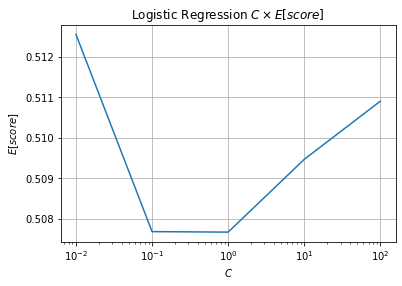

In [85]:
res = np.zeros(5)
for i, _v in enumerate(np.unique(results.cv_results_['param_model__C'])):
    cond = results.cv_results_['param_model__C'] == _v
    res[i] = np.nanmean(results.cv_results_['mean_test_score'][cond])
    
plt.grid()
plt.title(r'Logistic Regression $C \times E[score]$')
plt.plot(np.array(np.unique(results.cv_results_['param_model__C'])).astype(float), res)
plt.xlabel('$C$')
plt.ylabel('$E[score]$')
plt.xscale('log')
plt.show()

In [74]:
clf = bigraph_models[13]
data = multi_text.iloc[:,0]
data = data[data.notna()]
vectorized = data.progress_apply(lambda x: clf.vectorize(x,pad_with=0,strategy='pad_with',seq_length=np.max(data.str.len())))

In [84]:
#VEC    = vectorized.copy()
VEC_13 = vectorized.copy()

In [87]:
# def impute(x):
#     _x = pd.Series(x.copy()).fillna(0)
#     return _x.to_numpy()
# VEC = VEC.apply(impute)
# VEC = VEC.to_numpy()
# VEC = np.array([list(i) for i in VEC])

VEC_13 = VEC_13.apply(impute)
VEC_13 = VEC_13.to_numpy()
VEC_13 = np.array([list(i) for i in VEC_13])

In [57]:
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

In [60]:
N = 5
isomap = Isomap(n_components = N)
#tsne   = TSNE(n_components = N)
svd    = TruncatedSVD(n_components = N)
pca    = PCA(N)

In [61]:
#tsne.fit(VEC)
isomap.fit(VEC)
svd.fit(VEC)
pca.fit(VEC)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [90]:
# isomap_ld = isomap.transform(VEC)
# svd_ld    = svd.transform(VEC)
# pca_ld    = pca.transform(VEC)

isomap_ld_13 = isomap.fit_transform(VEC_13)
svd_ld_13    = svd.fit_transform(VEC_13)
pca_ld_13    = pca.fit_transform(VEC_13)

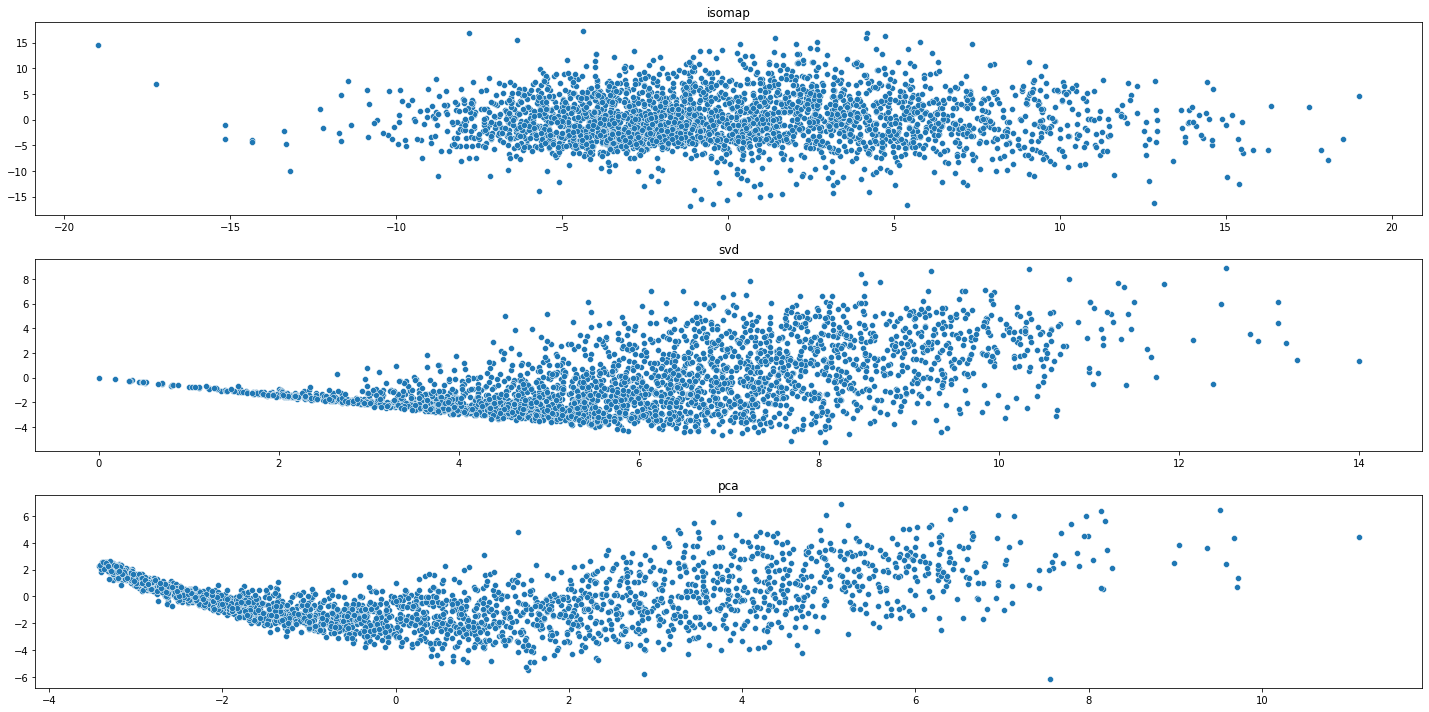

In [73]:
names  = ['isomap','svd','pca']
models = [isomap_ld,svd_ld,pca_ld]
plt.figure(figsize=(20,10))
for ax,(name,model) in enumerate(zip(names,models)):
    plt.subplot(3,1,ax+1)
    plt.title(name)
    sns.scatterplot(x=model[:,0],y=model[:,1])
    
plt.tight_layout()

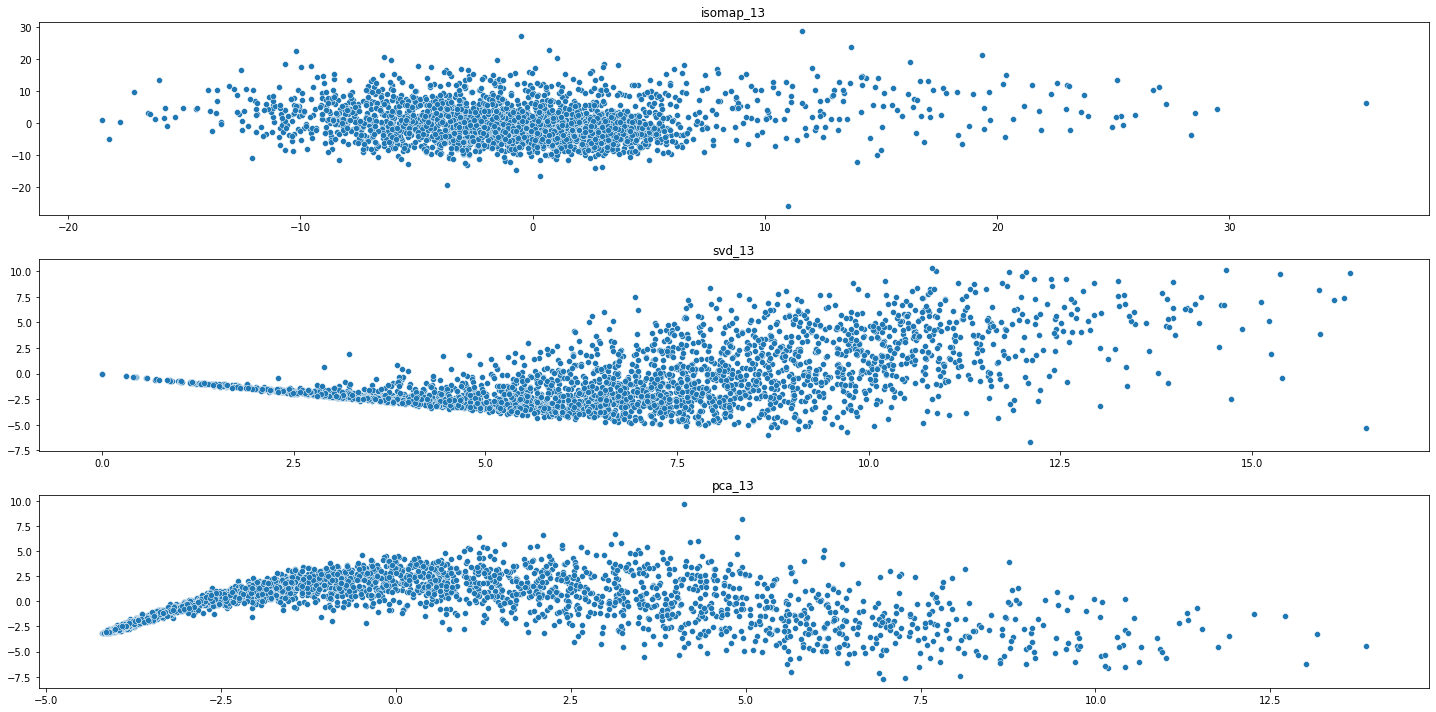

In [91]:
names  = ['isomap_13','svd_13','pca_13']
models = [isomap_ld_13,svd_ld_13,pca_ld_13]
plt.figure(figsize=(20,10))
for ax,(name,model) in enumerate(zip(names,models)):
    plt.subplot(3,1,ax+1)
    plt.title(name)
    sns.scatterplot(x=model[:,0],y=model[:,1])
    
plt.tight_layout()

In [78]:
import plotly.graph_objs as go
import plotly.express as ex

In [94]:
x_dat = isomap_ld[:,0]
y_dat = isomap_ld[:,1]

dec_df = pd.DataFrame({'dim_1':x_dat,'dim_2':y_dat,'text':data.apply(lambda x: x[:20] if len(x) > 20 else x)})
ex.scatter(dec_df,x='dim_1',y='dim_2',
          hover_data=['text'])

In [129]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

x_dat = isomap_ld[:,0]
y_dat = isomap_ld[:,1]

f_data = pd.DataFrame({'dim_1':x_dat,'dim_2':y_dat,'text':data.apply(lambda x: x[:20] if len(x) > 20 else x)})

sid = SIA()
f_data['sentiments']           = f_data['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
f_data['Positive Sentiment']   = f_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
f_data['Neutral Sentiment']    = f_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
f_data['Negative Sentiment']   = f_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

ex.scatter(f_data,x='dim_1',y='dim_2',color='Positive Sentiment',
          hover_data=['text'])

In [128]:
x_dat = isomap_ld[:,0]
y_dat = isomap_ld[:,1]
z_dat = isomap_ld[:,2]

f_data = pd.DataFrame({'dim_1':x_dat,'dim_2':y_dat,'dim_3':z_dat,'text':data.apply(lambda x: x[:20] if len(x) > 20 else x)})

sid = SIA()
f_data['sentiments']           = f_data['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
f_data['Positive Sentiment']   = f_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
f_data['Neutral Sentiment']    = f_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
f_data['Negative Sentiment']   = f_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

ex.scatter_3d(f_data,x='dim_1',y='dim_2',z='dim_3',color='Positive Sentiment',
          hover_data=['text'])

In [101]:
dec_df_13.loc[2527,:]

dim_1               35.871846
dim_2                6.183954
text     never used approache
Name: 2527, dtype: object

In [105]:
dec_df.loc[2527,:]

dim_1                2.491022
dim_2                 6.53133
text     never used approache
Name: 2527, dtype: object